In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
import warnings 
warnings.filterwarnings("ignore")

In [56]:
#Retrieving data(Webscraping from yahoo.com)
startt = dt.datetime(2020,1,1)
endd = dt.datetime(2021,1,1)

#sensex_data = web.DataReader("^BSESN",'yahoo',startt ,endd) 
sensex_data = pd.read_csv('^BSESN.csv')

sensex_data["Date"] = pd.to_datetime(sensex_data["Date"]).dt.normalize()
sensex_data["Date"].dtypes
sensex_data.set_index('Date', inplace = True)

sensex_data = sensex_data.sort_index(ascending = True, axis =0)
print(sensex_data)
sensex_data.shape

                    Open          High           Low         Close  \
Date                                                                 
2019-12-17  41052.359375  41401.648438  41005.179688  41352.171875   
2019-12-18  41442.750000  41614.769531  41358.468750  41558.570313   
2019-12-19  41571.820313  41719.289063  41456.398438  41673.921875   
2019-12-20  41746.199219  41809.960938  41636.109375  41681.539063   
2019-12-23  41548.261719  41701.621094  41474.609375  41642.660156   
...                  ...           ...           ...           ...   
2020-12-11  46060.320313  46309.628906  45706.218750  46099.011719   
2020-12-14  46284.699219  46373.339844  45951.531250  46253.460938   
2020-12-15  46287.390625  46350.300781  45841.671875  46263.171875   
2020-12-16  46573.308594  46704.968750  46402.199219  46666.460938   
2020-12-17  46774.320313  46992.570313  46627.601563  46890.339844   

               Adj Close   Volume  
Date                               
2019-12-17  41352

(252, 6)

In [57]:
#Data Cleaning
sensex_data = sensex_data.drop_duplicates()
sensex_data = sensex_data.dropna()
print(sensex_data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Text(0, 0.5, 'Closing Price')

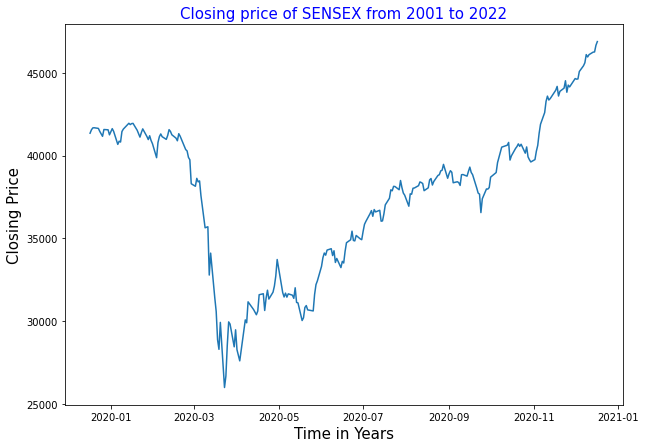

In [58]:
#SENSEX trend
plt.figure(figsize=(10,7))
sns.lineplot(x = "Date", y = "Close" , data = sensex_data)
plt.title("Closing price of SENSEX from 2001 to 2022", size = 15, color = "blue")
plt.xticks(size = "10")
plt.yticks(size = "10")
plt.xlabel("Time in Years", size = 15)
plt.ylabel("Closing Price", size = 15)

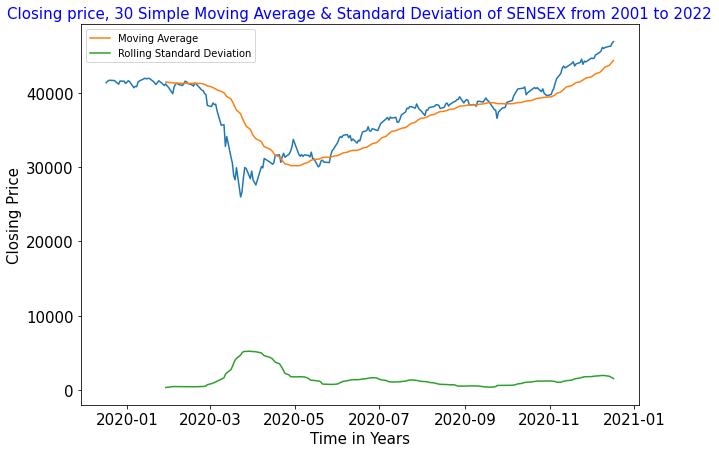

In [59]:
plt.figure(figsize=(10,7))
sns.lineplot(x = "Date", y = "Adj Close" , data = sensex_data)
rollng_mean = sensex_data.rolling(window = 30).mean()['Adj Close']
sns.lineplot(x = "Date", y = rollng_mean, data = sensex_data, label = "Moving Average")
rollng_std = sensex_data.rolling(window = 30).std()["Adj Close"]
sns.lineplot(x = "Date", y = rollng_std, data = sensex_data, label = "Rolling Standard Deviation")
plt.title("Closing price, 30 Simple Moving Average & Standard Deviation of SENSEX from 2001 to 2022", size = 15, color = "blue")
plt.xticks(size = "15")
plt.yticks(size = "15")
plt.xlabel("Time in Years", size = 15)
plt.ylabel("Closing Price", size = 15)
plt.show()

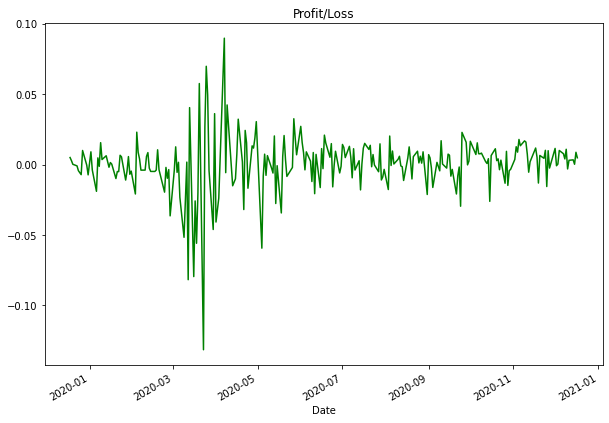

In [60]:
#Plotting profit and loss
PL = sensex_data["Adj Close"] / sensex_data["Adj Close"].shift(1) - 1
plt.figure(figsize=(10,7))
PL.plot(label = 'P/L', color = 'green')
plt.title("Profit/Loss")
plt.show()

In [61]:
#Augmented dicky fuller test to see stationary data
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("\n1. ADF: ", dftest[0])
    print("\n2. P-Value: ", dftest[1])
    print("\n3. Num. of lags: ", dftest[2])
    print("\n4. Num of observations used for ADF regression and critical value calculations: ", dftest[3])
    print("\n5. Critical Values: ")
    for key, val in dftest[4].items():
        print("\t", key, ":", val)

ad_test(sensex_data['Adj Close'])
#P-value greater than 0.5


1. ADF:  -0.6982850827498318

2. P-Value:  0.84719324017088

3. Num. of lags:  6

4. Num of observations used for ADF regression and critical value calculations:  243

5. Critical Values: 
	 1% : -3.4575505077947746
	 5% : -2.8735087323013526
	 10% : -2.573148434859185


In [62]:
#Figuring out order for ARIMA Model
arimafit = auto_arima(sensex_data["Adj Close"], trace = True, suppress_warnings = True)
arimafit.summary()
#Minimium AIC score (1,2,2)(0,0,0) minimum

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4123.236, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=4079.086, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=4065.608, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=4063.777, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=4065.306, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=4063.631, Time=0.31 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=4064.408, Time=0.09 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=4064.464, Time=0.32 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=4066.516, Time=0.09 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=4073.664, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=4065.344, Time=0.26 sec

Best model:  ARIMA(1,2,2)(0,0,0)[0]          
Total fit time: 2.085 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -2027.816
Date:                Sun, 19 Jun 2022   AIC                           4063.631
Time:                        23:57:26   BIC                           4077.685
Sample:                             0   HQIC                          4069.289
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9119      0.045    -20.152      0.000      -1.001      -0.823
ma.L1          0.4863      0.053      9.121      0.000       0.382       0.591
ma.L2         -0.4360      0.019    -22.501      0.000      -0.474      -0.398
sigma2      6.101e+05   3.08e+04     19.812      0.000     5.5e+05     6.7e+05
===================================================================================
Ljung-Box (L1) (Q):                  20.01   Jarque-Bera (JB):               527.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
#Training and Testing data
#train, test = train_test_split(sensex_data, test_size = 0.3)
train =  sensex_data.iloc[:-40]
test =  sensex_data.iloc[-40:]
print(sensex_data.shape)
print(train.shape)
print(test.shape)

(250, 6)
(210, 6)
(40, 6)


In [64]:
#Training the ARIMA Model
model = sm.tsa.arima.ARIMA(train["Adj Close"], order = (1,2,2))
model = model.fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  210
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1717.899
Date:                Sun, 19 Jun 2022   AIC                           3443.799
Time:                        23:57:26   BIC                           3457.149
Sample:                             0   HQIC                          3449.197
                                - 210                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9683      0.021    -46.841      0.000      -1.009      -0.928
ma.L1          0.5898      0.032     18.166      0.000       0.526       0.653
ma.L2         -0.3931      0.023    -17.379      0.000      -0.437      -0.349
sigma2      7.391e+05   4.67e+04     15.834      0.000    6.48e+05    8.31e+05
===================================================================================
Ljung-Box (L1) (Q):                  19.73   Jarque-Bera (JB):               395.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
#Make Predictions on Test Set
start = len(train)
end = len(train) + len(test)-1
pred = model.predict(start = start, end = end, typ = 'levels')
pred.index = sensex_data.index[start:end+1]
print(pred)
pred.shape

Date
2020-10-21    40820.778587
2020-10-22    40941.767801
2020-10-23    41213.252906
2020-10-26    41339.008607
2020-10-27    41605.878189
2020-10-28    41736.103230
2020-10-29    41998.645024
2020-10-30    42133.060785
2020-11-02    42391.544586
2020-11-03    42529.889815
2020-11-04    42784.568603
2020-11-05    42926.598333
2020-11-06    43177.709314
2020-11-09    43323.193852
2020-11-10    43570.959446
2020-11-11    43719.683417
2020-11-12    43964.312177
2020-11-13    44116.073632
2020-11-17    44357.761110
2020-11-18    44512.370691
2020-11-19    44751.300249
2020-11-20    44908.580402
2020-11-23    45144.923970
2020-11-24    45304.708209
2020-11-25    45538.627000
2020-11-26    45700.759220
2020-11-27    45932.404395
2020-12-01    46096.738220
2020-12-02    46326.251519
2020-12-03    46492.649700
2020-12-04    46720.164025
2020-12-07    46888.497869
2020-12-08    47114.137837
2020-12-09    47284.286674
2020-12-10    47508.169134
2020-12-11    47680.019814
2020-12-14    47902.254

(40,)

<AxesSubplot:xlabel='Date'>

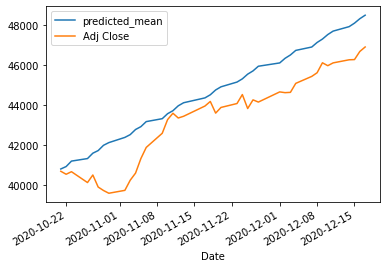

In [66]:
pred.plot(legend = True)
test['Adj Close'].plot(legend = True)

In [67]:
print(test['Adj Close'].mean())


43318.79931655


In [68]:
rmse = sqrt(mean_squared_error(pred, test['Adj Close']))
print(rmse)

1463.8913719575576


In [69]:
#Future Prediction
model2 = sm.tsa.arima.ARIMA(sensex_data['Adj Close'], order = (1,2,2))
model2 = model2.fit()
sensex_data.tail()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,46099.011719,26300.0
2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,46253.460938,18400.0
2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,46263.171875,16400.0
2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,46666.460938,13100.0
2020-12-17,46774.320313,46992.570313,46627.601563,46890.339844,46890.339844,0.0


In [70]:
#Future dates
index_future_dates = pd.date_range(start = '2020-12-17', end = '2021-01-16')
print(index_future_dates)

DatetimeIndex(['2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31', '2021-01-01',
               '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09',
               '2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15', '2021-01-16'],
              dtype='datetime64[ns]', freq='D')


In [71]:
pred = model2.predict(start = len(sensex_data), end = len(sensex_data) + 30, typ = 'levels').rename("ARIMA Predictions")
pred.index = index_future_dates
print(pred)

2020-12-17    47189.715118
2020-12-18    47401.560116
2020-12-19    47693.223754
2020-12-20    47912.100973
2020-12-21    48197.351947
2020-12-22    48422.076859
2020-12-23    48701.995336
2020-12-24    48931.582938
2020-12-25    49207.067140
2020-12-26    49440.698347
2020-12-27    49712.495196
2020-12-28    49949.488891
2020-12-29    50218.219495
2020-12-30    50458.009291
2020-12-31    50724.190138
2021-01-01    50966.305051
2021-01-02    51230.365629
2021-01-03    51474.414010
2021-01-04    51736.711464
2021-01-05    51982.367633
2021-01-06    52243.198948
2021-01-07    52490.192086
2021-01-08    52749.804223
2021-01-09    52997.909127
2021-01-10    53256.507448
2021-01-11    53505.536847
2021-01-12    53763.292123
2021-01-13    54013.090294
2021-01-14    54270.144528
2021-01-15    54520.581976
2021-01-16    54777.053255
Freq: D, Name: ARIMA Predictions, dtype: float64


<AxesSubplot:>

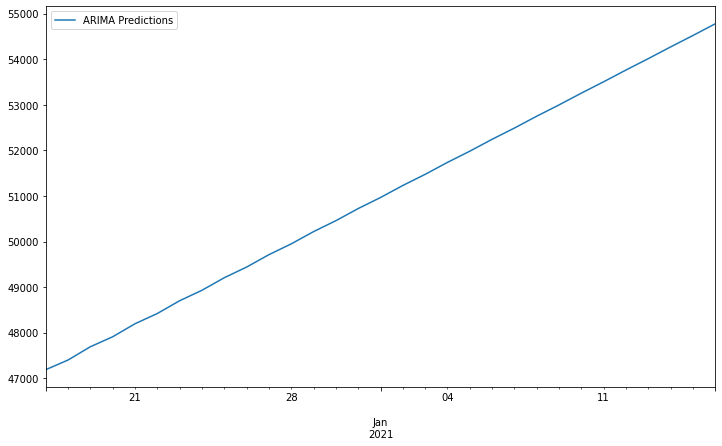

In [72]:
pred.plot(figsize=(12,7), legend = True)